# Get Metadata for PMID papers
Goes from PMID -> DOI -> Full text jsons.

Dependency: brenda_rxns_incomplete.

In [2]:
import urllib
import requests
import os
import math
import json
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np

import igemutils as igem

email = 'ivalexander13@berkeley.edu' # enter ur email pls

**Loading some files**

In [3]:
rxns = pd.read_csv("../Data_CSVs/brenda_rxns_incomplete.csv")

print(f"Number of unique PMIDs in rxns: {rxns.pubmedId.unique().size}.")
print(f"Number of rows: {len(rxns)}.")
print(rxns.columns)

Number of unique PMIDs in rxns: 103948.
Number of rows: 459935.
Index(['Unnamed: 0', 'literatureProducts', 'literatureSubstrates',
       'organismSubstrates', 'commentarySubstrates', 'reversibility',
       'organismProducts', 'products', 'commentaryProducts', 'substrates',
       'ecNumber', 'pubmedId'],
      dtype='object')


In [4]:
rxns.head()

,Unnamed: 0,literatureProducts,literatureSubstrates,organismSubstrates,commentarySubstrates,reversibility,organismProducts,products,commentaryProducts,substrates,ecNumber,pubmedId
0,0,NaN,695811.0,Thermus sp.,1% activity compared to cyclohexanone,?,NaN,? + NAD+,NaN,(-)-carvone + NADH + H+,1.1.1.1,18704396.0
1,1,NaN,695811.0,Thermus sp.,125% activity compared to cyclohexanol,r,NaN,(rac)-3-methylcyclohexanone + NADH + H+,163% activity compared to cyclohexanone,"(1S,3S)-3-methylcyclohexanol + NAD+",1.1.1.1,18704396.0
2,2,NaN,735498.0,Yokenella sp.,"41.5% of the activity with (2E)-but-2-enal, yi...",?,NaN,(2E)-2-methylpent-2-en-1-ol + NADP+,NaN,(2E)-2-methylpent-2-enal + NADPH + H+,1.1.1.1,24509923.0
3,3,NaN,735498.0,Yokenella sp.,"37.4% of the activity with (2E)-but-2-enal, yi...",?,NaN,"(2E)-3,7-dimethylocta-2,6-dien-1-ol + NADP+",NaN,"(2E)-3,7-dimethylocta-2,6-dienal + NADPH + H+",1.1.1.1,24509923.0
4,4,NaN,691867.0,Homo sapiens,substrate of isozyme ADH4,r,NaN,"(2E)-non-2-ene-1,4-diol + NAD+",NaN,(2E)-4-hydroxynon-2-enal + NADH + H+,1.1.1.1,18505683.0


## Data Cleaning

The column 'pubmedId' has many zeroes and some NaNs. These should be excluded.

In [5]:
# Some cleaning
rxns.drop(columns=["Unnamed: 0"])

rxns_a = rxns.copy()
rxns['pubmedIdClean'] = rxns[['pubmedId']].fillna(value=0)

rxns = rxns.astype({'pubmedIdClean': 'int64'})
rxns = rxns.astype({'pubmedIdClean': 'str'})
len(rxns_a)

459935

In [6]:
# Getting the list of PMID's for processing
rxn_pmids = rxns.pubmedIdClean.unique()
print(f"Length of unique PMID's: {rxn_pmids.size}")
rxn_pmids

Length of unique PMID's: 103947


array(['18704396', '24509923', '18505683', ..., '28035596', '23979139',
       '29507090'], dtype=object)

## Unpaywall API
Slow! Took 24+ hours.

In [7]:
unpaywall_metadata = igem.get_json('./get_metadata_pmidset/unpaywall_metadata_pmids.json')

In [7]:
# Output file = doi to full_text dict dictionary (in json)
jsopn_file = './get_metadata_pmidset/unpaywall_metadata_pmids.json'
unpaywall_metadata = igem.get_json(json_file)
     
# user edit
max_calls = 99000 # max 100K per day (to be safe); or -1 if querying all.

# stats
calls = 0
queries = 0
no_doi = [] # pmids
no_metadata = [] # pmids
successes_or_found = 0


# MAIN LOOP
try:
    for pmid in rxn_pmids:
        if calls < -1:
            calls +=1
            print(f"Call {calls} skipped.")
            continue;
            
        # stop before maxing out query
        if queries == max_calls or (queries == 99999):
            print("Query limit reached.")
            break
        calls += 1
                    
        # check if metada already exists 
        if pmid in unpaywall_metadata:
            successes_or_found += 1
            print(f"## Call {calls}: exists.")
            continue;
            
        # doi check
        doi = igem.pmid2doi(pmid)
        if not doi:
            no_doi.append(pmid)
            print(f"#### Call {calls}: no DOI")
            continue;
            
        # metadata check
        metadata = igem.get_metadata(doi, email)
        if not metadata:
            no_metadata.append(pmid)
            print(f"###### Call {calls}: no metadata")
            continue;
            
        unpaywall_metadata[pmid] = metadata
        successes_or_found +=1
        queries +=1
        print(f"Call {calls} success.")
        
        # checkpoint stats
        if calls % 50 == 0:
            print(f"######### STATS: {calls} calls, {successes_or_found} good, {len(no_doi)} no DOI, {len(no_metadata)} no metadata.")
        
        # save to file
        if calls % 50 == 0:
            with open(json_file, 'w') as fp:
                json.dump(unpaywall_metadata, fp)
                fp.close()
            
except KeyboardInterrupt:
    pass

# save to file
igem.save_json(json_file, unpaywall_metadata)
        
# Print Stats
print("")
print("###### STATS ######")
print(f"Total calls: {calls}")
print(f"Total number of queries: {queries}")
print(f"Number of fail due to no DOI: {len(no_doi)}")
print(f"Number of fail due to no metadata: {len(no_metadata)}")
print(f"Papers in storage: {len(unpaywall_metadata)}")


Call 1 skipped.
Call 2 skipped.
Call 3 skipped.
Call 4 skipped.
Call 5 skipped.
Call 6 skipped.
Call 7 skipped.
Call 8 skipped.
Call 9 skipped.
Call 10 skipped.
Call 11 skipped.
Call 12 skipped.
Call 13 skipped.
Call 14 skipped.
Call 15 skipped.
Call 16 skipped.
Call 17 skipped.
Call 18 skipped.
Call 19 skipped.
Call 20 skipped.
Call 21 skipped.
Call 22 skipped.
Call 23 skipped.
Call 24 skipped.
Call 25 skipped.
Call 26 skipped.
Call 27 skipped.
Call 28 skipped.
Call 29 skipped.
Call 30 skipped.
Call 31 skipped.
Call 32 skipped.
Call 33 skipped.
Call 34 skipped.
Call 35 skipped.
Call 36 skipped.
Call 37 skipped.
Call 38 skipped.
Call 39 skipped.
Call 40 skipped.
Call 41 skipped.
Call 42 skipped.
Call 43 skipped.
Call 44 skipped.
Call 45 skipped.
Call 46 skipped.
Call 47 skipped.
Call 48 skipped.
Call 49 skipped.
Call 50 skipped.
Call 51 skipped.
Call 52 skipped.
Call 53 skipped.
Call 54 skipped.
Call 55 skipped.
Call 56 skipped.
Call 57 skipped.
Call 58 skipped.
Call 59 skipped.
Call 6

### More Data!

In [16]:
len(unpaywall_metadata)

96218

Get stats

In [8]:
import operator

def get_publisher_stats(metadata_dict):
    publishers = {}
    are_oa = 0
    for key, value in metadata_dict.items():
        pub = value['publisher']
        is_oa = value['is_oa']

        # Check by publisher
        if True:
            if pub not in publishers:
                    publishers[pub] = 1
            else:
                publishers[pub] += 1

        # check if paper is oa
        if is_oa:
            are_oa += 1


    sorted_x = sorted(publishers.items(), key=operator.itemgetter(1), reverse=True)
    sorted_x

    num_elsevier_papers = sum([v[1] for i, v in enumerate(sorted_x) if v[0] == 'Elsevier' or v[0] == 'Elsevier BV'])

    num_E_S_W = sum([v[1] for i, v in enumerate(sorted_x) if 
                     v[0] == 'Elsevier' 
                     or v[0] == 'Elsevier BV' 
                     or v[0] == 'Springer Science and Business Media LLC'
                     or v[0] == 'Wiley'
                    ])


    # printouts
    print(f"Number of Elsevier papers in total: {num_elsevier_papers}.")
    print(f"Total papers that we have = elsevier + OA = {num_elsevier_papers} + {are_oa} = {num_elsevier_papers + are_oa}")
    print(f"% if fetching from Elsevier + Springer + Wiley = {num_E_S_W + are_oa} / {len(rxns_a['pubmedId'].unique())} = {(num_E_S_W + are_oa) / len(rxns_a['pubmedId'].unique()) * 100}%")
    return sorted_x[0:10]
get_publisher_stats(unpaywall_metadata)

Number of Elsevier papers in total: 26878.
Total papers that we have = elsevier + OA = 26878 + 46843 = 73721
% if fetching from Elsevier + Springer + Wiley = 95421 / 103948 = 91.79685996844576%


[('Elsevier BV', 25593),
 ('Wiley', 12194),
 ('Springer Science and Business Media LLC', 9506),
 ('American Chemical Society (ACS)', 8349),
 ('American Society for Biochemistry & Molecular Biology (ASBMB)', 7737),
 ('American Society for Microbiology', 5704),
 ('Oxford University Press (OUP)', 4472),
 ('Portland Press Ltd.', 2956),
 ('Proceedings of the National Academy of Sciences', 2057),
 ('Informa UK Limited', 1861)]

### Create Subsets

In [9]:
""" Generate a subset of the metadata_dict, which has to be a {pmid: {metadata}} type.
Set the return_complement param to True if you want the non-matching entries to be populated.
RETURN: a tuple! Index [0] to get the subset and [1] to get the complement.
"""
def generate_subset(metadata_dict, field, values, return_complement=False):
    subset_dict = {}
    complement_dict = {}
    count_match = 0
    count_nomatch = 0
    
    for value in values:
        for pmid, meta in metadata_dict.items():
            field_value = meta[field] == value
            if field_value:
                subset_dict[pmid] = meta
                count_match += 1
                continue;
            count_nomatch +=1
            if return_complement:
                complement_dict[pmid] = meta

    print(f"Count of {field} being {values}: {count_match}.")
    if return_complement:
        print(f"Count of {field} not matching {values}: {count_nomatch}.")
    
    return subset_dict, complement_dict

In [10]:
# 1. Split into OA and non OA
unpaywall_oa_subset, unpaywall_non_oa_subset = generate_subset(unpaywall_metadata, 'is_oa', [True], return_complement=True)

Count of is_oa being [True]: 46843.
Count of is_oa not matching [True]: 49375.


In [11]:
get_publisher_stats(unpaywall_oa_subset)

Number of Elsevier papers in total: 3611.
Total papers that we have = elsevier + OA = 3611 + 46843 = 50454
% if fetching from Elsevier + Springer + Wiley = 59850 / 103948 = 57.576865355754805%


[('American Society for Biochemistry & Molecular Biology (ASBMB)', 7598),
 ('Wiley', 6783),
 ('American Society for Microbiology', 5703),
 ('Elsevier BV', 3592),
 ('Oxford University Press (OUP)', 3049),
 ('Portland Press Ltd.', 2686),
 ('Springer Science and Business Media LLC', 2613),
 ('Proceedings of the National Academy of Sciences', 2057),
 ('American Chemical Society (ACS)', 1907),
 ('American Society of Plant Biologists (ASPB)', 1730)]

In [12]:
get_publisher_stats(unpaywall_non_oa_subset)

Number of Elsevier papers in total: 23267.
Total papers that we have = elsevier + OA = 23267 + 0 = 23267
% if fetching from Elsevier + Springer + Wiley = 35571 / 103948 = 34.21999461269096%


[('Elsevier BV', 22001),
 ('Springer Science and Business Media LLC', 6893),
 ('American Chemical Society (ACS)', 6442),
 ('Wiley', 5411),
 ('Oxford University Press (OUP)', 1423),
 ('Elsevier', 1266),
 ('Informa UK Limited', 1186),
 ('Walter de Gruyter GmbH', 575),
 ('International Union of Crystallography (IUCr)', 458),
 ('Springer Nature', 370)]

**OA papers will be in its own dataset, and the non-oa ones will be called by their respective APIs**

### Generating Subsets!
Do this for API calls (in other notebooks)

In [14]:
elsevier_subset = generate_subset(unpaywall_non_oa_subset, 'publisher', ['Elsevier', 'Elsevier BV'])[0]
springer_subset = generate_subset(unpaywall_non_oa_subset, 'publisher', ['Springer Science and Business Media LLC', 'Springer Nature'])[0]
wiley_subset = generate_subset(unpaywall_non_oa_subset, 'publisher', ['Wiley'])[0]

Count of publisher being ['Elsevier', 'Elsevier BV']: 23267.
Count of publisher being ['Springer Science and Business Media LLC', 'Springer Nature']: 7263.
Count of publisher being ['Wiley']: 5411.


### Plotting

In [24]:
def make_hist(data_dict, value_field):
    year_lim = 1995

    before=0
    after=0
    unknown=0

    counts = []
    for key, value in data_dict.items():
        year = value[value_field]

        if not year:
            unknown += 1 
            continue
            
        counts.append(year)

    df = pd.DataFrame(counts)
    return df.hist(bins=len(df[0].unique()))
    
    # print(f"Before {year_lim}: {before}")
    # print(f"After {year_lim}: {after}")
    # print(f"Unknown {year_lim}: {unknown}")

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

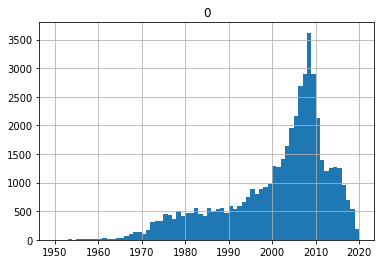

In [25]:
make_hist(unpaywall_non_oa_subset, 'year')